In [34]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

# Some useful functions for plotting loss and accuracy, using training history
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# A function for showing confusion matrix as a heatmap    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


In [36]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/Datasets/merged_training.pkl")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
print(df)

                                                     text emotions
27383   i feel awful about it too because it s my job ...  sadness
110083                              im alone i feel awful  sadness
140764  ive probably mentioned this before but i reall...      joy
100071           i was feeling a little low few days back  sadness
2837    i beleive that i am much more sensitive to oth...     love
...                                                   ...      ...
566     that was what i felt when i was finally accept...      joy
36236   i take every day as it comes i m just focussin...     fear
76229       i just suddenly feel that everything was fake  sadness
131640  im feeling more eager than ever to claw back w...      joy
64703   i give you plenty of attention even when i fee...  sadness

[416809 rows x 2 columns]


In [38]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [39]:
print(train.shape)
print(validate.shape)
print(test.shape)
print(validate)
print(test)

(250085, 2)
(83362, 2)
(83362, 2)
                                                     text emotions
5131    i am feeling a bit im obviously not clever eno...      joy
34095                               i feel cute sometimes      joy
137799      im still feeling confident for the race espec      joy
83705   i have added bold text to the passages that i ...      joy
65093   i feel strong and fit to an extent but i dont ...      joy
...                                                   ...      ...
9631    i don t feel vulnerable admitting it in fact a...     fear
19889   i croak the last of that feeling myself wilt a...      joy
64017   i feel so rich in the love of my friends and f...      joy
10987   i am really happy the cross arms hand holdings...      joy
32982   im feeling very horny today so i just texted e...     love

[83362 rows x 2 columns]
                                                    text  emotions
17577  i cant wait for it to warm up so we can explor...       joy
11

In [40]:
def get_tweets(data):
    tweets = data['text'].tolist()
    labels = data['emotions'].tolist()
    return tweets, labels

In [41]:
tweets, labels = get_tweets(train)

In [42]:
tweets[1],labels[1]

('ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing',
 'sadness')

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [44]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 32, 3, 41, 289, 4, 1468, 2994]]


In [45]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

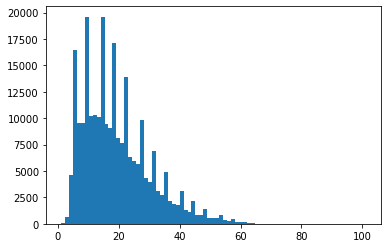

In [46]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()
# The majority of sentences have less than 50 words, we are going to use 50 as maximum length of our sequences

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:

# A function for making sequences and padding
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences


In [49]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [50]:
padded_train_sequences[0]

array([   2,   32,    3,   41,  289,    4, 1468, 2994,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [51]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'love', 'anger', 'fear', 'sadness'}


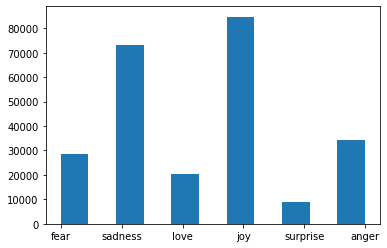

In [52]:
plt.hist(labels, bins=11)
plt.show()

In [53]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [54]:
classes_to_index

{'surprise': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'sadness': 5}

In [55]:
index_to_classes

{0: 'surprise', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'sadness'}

In [56]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [57]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


In [58]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [59]:
val_tweets, val_labels = get_tweets(validate)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [60]:
val_tweets[0], val_labels[0]

('i am feeling a bit im obviously not clever enough to get this stuff right now',
 1)

In [61]:
import pickle

h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

model.save('emotion_model')



Epoch 1/5
7816/7816 [==============================] - 109s 13ms/step - loss: 0.3180 - accuracy: 0.8736 - val_loss: 0.1327 - val_accuracy: 0.9288
Epoch 2/5
7816/7816 [==============================] - 103s 13ms/step - loss: 0.1155 - accuracy: 0.9343 - val_loss: 0.1086 - val_accuracy: 0.9346
Epoch 3/5
7816/7816 [==============================] - 102s 13ms/step - loss: 0.0978 - accuracy: 0.9398 - val_loss: 0.1015 - val_accuracy: 0.9375
Epoch 4/5
7816/7816 [==============================] - 103s 13ms/step - loss: 0.0924 - accuracy: 0.9412 - val_loss: 0.0990 - val_accuracy: 0.9359
Epoch 5/5
7816/7816 [==============================] - 103s 13ms/step - loss: 0.0890 - accuracy: 0.9424 - val_loss: 0.0979 - val_accuracy: 0.9377


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [64]:
_ = model.evaluate(test_sequences, test_labels)

2606/2606 [==============================] - 14s 5ms/step - loss: 0.0955 - accuracy: 0.9397


In [65]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))
classof=np.argmax(p,axis=1)

print('Predicted Emotion:', index_to_classes.get(classof[0]))

Sentence: i wanted to turn around and politely offer my point of view but unlike bars and cafes where i feel that joining in on overheard conversations is usually acceptable the whole a href http www
Emotion: joy
1/1 [==============================] - 1s 1s/step
Predicted Emotion: joy


In [66]:
sentence = "I feel so disappointed! I hate my life!"
sequence = get_sequences(tokenizer, [sentence,])[0]

p = model.predict(np.expand_dims(sequence, axis=0))
classof=np.argmax(p,axis=1)

print(index_to_classes.get(classof[0]))

1/1 [==============================] - 0s 20ms/step
sadness
